# Classification Model Comparison: Performance vs Efficiency Trade-offs

This notebook demonstrates how to evaluate and compare different classification models on a real-world dataset, considering both performance metrics and computational efficiency. We'll use the **Breast Cancer Wisconsin dataset** - a real medical dataset with slight class imbalance that's commonly used in machine learning research.

## Learning Objectives
- Understand how to evaluate classification models comprehensively
- Learn about the trade-offs between model complexity, performance, and efficiency
- Practice implementing multiple evaluation metrics
- Gain insights into model selection for real-world applications

## Dataset Overview
The Breast Cancer Wisconsin dataset contains features computed from digitized images of breast cancer cells. It's a binary classification problem where we predict whether a tumor is malignant (1) or benign (0). The dataset has:
- 569 samples
- 30 features (mean, standard error, and worst values for 10 characteristics)
- Slight class imbalance (~37% malignant, ~63% benign)


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline


## Step 1: Data Loading and Exploration

Let's start by loading the Breast Cancer Wisconsin dataset and exploring its characteristics.


In [ ]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Create a DataFrame for easier manipulation
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Samples: {len(y)}")
print("\nTarget distribution:")
print(f"Benign (0): {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"Malignant (1): {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
df.head()


Dataset Information:
Shape: (569, 31)
Features: 30
Samples: 569

Target distribution:
Benign (0): 212 (37.3%)
Malignant (1): 357 (62.7%)

First 5 rows of the dataset:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


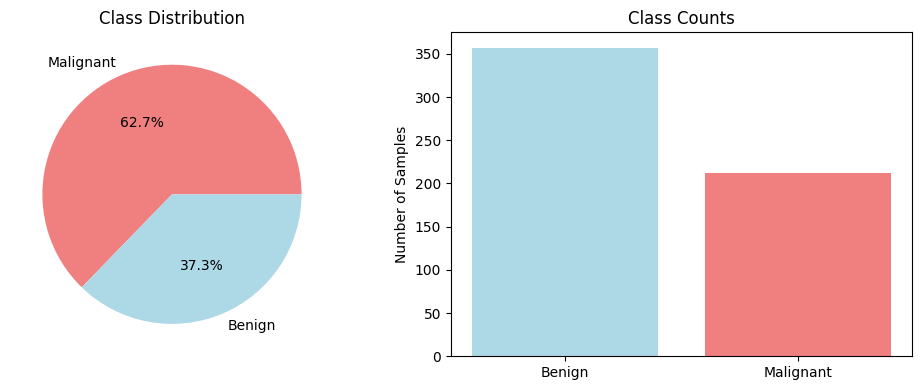

Class imbalance ratio: 0.59:1 (Benign:Malignant)


In [ ]:
# Visualize the class distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
target_counts = pd.Series(y).value_counts()
plt.pie(target_counts.values, labels=['Malignant', 'Benign'], autopct='%1.1f%%',
        colors=['lightcoral', 'lightblue'])
plt.title('Class Distribution')

plt.subplot(1, 2, 2)
plt.bar(['Benign', 'Malignant'], target_counts.values, color=['lightblue', 'lightcoral'])
plt.title('Class Counts')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()

print(f"Class imbalance ratio: {target_counts[0]/target_counts[1]:.2f}:1 (Benign:Malignant)")


## Step 2: Data Preprocessing

Before training our models, we need to prepare the data by splitting it into training and testing sets, and scaling the features for optimal performance.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Feature dimensionality: {X_train.shape[1]}")

# Check class distribution in train/test sets
print(f"\nTraining set distribution:")
train_counts = pd.Series(y_train).value_counts()
print(f"Benign: {train_counts[0]} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"Malignant: {train_counts[1]} ({train_counts[1]/len(y_train)*100:.1f}%)")

print(f"\nTesting set distribution:")
test_counts = pd.Series(y_test).value_counts()
print(f"Benign: {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"Malignant: {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")


Training set size: 455 samples
Testing set size: 114 samples
Feature dimensionality: 30

Training set distribution:
Benign: 170 (37.4%)
Malignant: 285 (62.6%)

Testing set distribution:
Benign: 42 (36.8%)
Malignant: 72 (63.2%)


In [ ]:
# Scale the features for optimal performance
# Note: Random Forest doesn't require scaling, but Logistic Regression benefits from it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Original feature ranges (first 5 features):")
for i in range(5):
    print(f"Feature {i}: [{X_train[:, i].min():.2f}, {X_train[:, i].max():.2f}]")

print(f"\nScaled feature ranges (first 5 features):")
for i in range(5):
    print(f"Feature {i}: [{X_train_scaled[:, i].min():.2f}, {X_train_scaled[:, i].max():.2f}]")


Feature scaling completed!
Original feature ranges (first 5 features):
Feature 0: [6.98, 28.11]
Feature 1: [9.71, 39.28]
Feature 2: [43.79, 188.50]
Feature 3: [143.50, 2499.00]
Feature 4: [0.06, 0.14]

Scaled feature ranges (first 5 features):
Feature 0: [-2.03, 4.02]
Feature 1: [-2.17, 4.55]
Feature 2: [-1.98, 4.02]
Feature 3: [-1.47, 5.37]
Feature 4: [-2.50, 3.61]


## Step 3: Model Definition and Training

Now we'll define and train our three classification models:

1. **Logistic Regression**: Simple, fast, highly interpretable linear model
2. **Random Forest**: Robust ensemble method with good performance and feature importance
3. **Gradient Boosting**: Advanced ensemble method, often highest performance but more complex

We'll measure both training time and prediction time for each model.


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

print("Training Models...")
print("=" * 50)

# Train each model and measure training time
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Choose appropriate data (scaled for Logistic Regression, original for tree-based models)
    X_train_model = X_train_scaled if name == 'Logistic Regression' else X_train
    X_test_model = X_test_scaled if name == 'Logistic Regression' else X_test

    # Measure training time
    start_time = time.time()
    model.fit(X_train_model, y_train)
    training_time = time.time() - start_time

    # Measure prediction time (multiple runs for better estimate)
    prediction_times = []
    for _ in range(100):  # Run 100 times for better estimate
        start_time = time.time()
        _ = model.predict(X_test_model)
        prediction_times.append(time.time() - start_time)

    avg_prediction_time = np.mean(prediction_times)
    prediction_time_per_sample = avg_prediction_time / len(X_test_model) * 1000  # ms per sample

    # Get predictions
    y_pred = model.predict(X_test_model)

    # Store results
    results[name] = {
        'model': model,
        'X_test': X_test_model,
        'y_pred': y_pred,
        'training_time': training_time,
        'prediction_time_per_sample': prediction_time_per_sample
    }

    print(f"Training time: {training_time:.4f} seconds")
    print(f"Average prediction time per sample: {prediction_time_per_sample:.4f} ms")

print("\nAll models trained successfully!")


Training Models...

Training Logistic Regression...
Training time: 0.0223 seconds
Average prediction time per sample: 0.0007 ms

Training Random Forest...
Training time: 0.1721 seconds
Average prediction time per sample: 0.0319 ms

Training Gradient Boosting...
Training time: 0.3185 seconds
Average prediction time per sample: 0.0028 ms

All models trained successfully!


## Step 4: Performance Evaluation

Now we'll evaluate each model using multiple metrics to understand their strengths and weaknesses.


In [ ]:
# Calculate performance metrics for each model
performance_metrics = {}

print("Performance Metrics")
print("=" * 60)

for name in models.keys():
    y_pred = results[name]['y_pred']

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    performance_metrics[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Training Time (s)': results[name]['training_time'],
        'Prediction Time (ms/sample)': results[name]['prediction_time_per_sample']
    }

    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Training Time: {results[name]['training_time']:.4f} seconds")
    print(f"  Prediction Time: {results[name]['prediction_time_per_sample']:.4f} ms/sample")

# Create a comprehensive comparison DataFrame
comparison_df = pd.DataFrame(performance_metrics).T
print(f"\n\nComparison Summary:")
print(comparison_df.round(4))


Performance Metrics

Logistic Regression:
  Accuracy:  0.9825
  Precision: 0.9861
  Recall:    0.9861
  F1-Score:  0.9861
  Training Time: 0.0223 seconds
  Prediction Time: 0.0007 ms/sample

Random Forest:
  Accuracy:  0.9561
  Precision: 0.9589
  Recall:    0.9722
  F1-Score:  0.9655
  Training Time: 0.1721 seconds
  Prediction Time: 0.0319 ms/sample

Gradient Boosting:
  Accuracy:  0.9561
  Precision: 0.9467
  Recall:    0.9861
  F1-Score:  0.9660
  Training Time: 0.3185 seconds
  Prediction Time: 0.0028 ms/sample


Comparison Summary:
                     Accuracy  Precision  Recall  F1-Score  Training Time (s)  \
Logistic Regression    0.9825     0.9861  0.9861    0.9861             0.0223   
Random Forest          0.9561     0.9589  0.9722    0.9655             0.1721   
Gradient Boosting      0.9561     0.9467  0.9861    0.9660             0.3185   

                     Prediction Time (ms/sample)  
Logistic Regression                       0.0007  
Random Forest                

## Step 5: Visual Comparison of Performance Metrics

Let's create visualizations to better understand the performance differences between models.


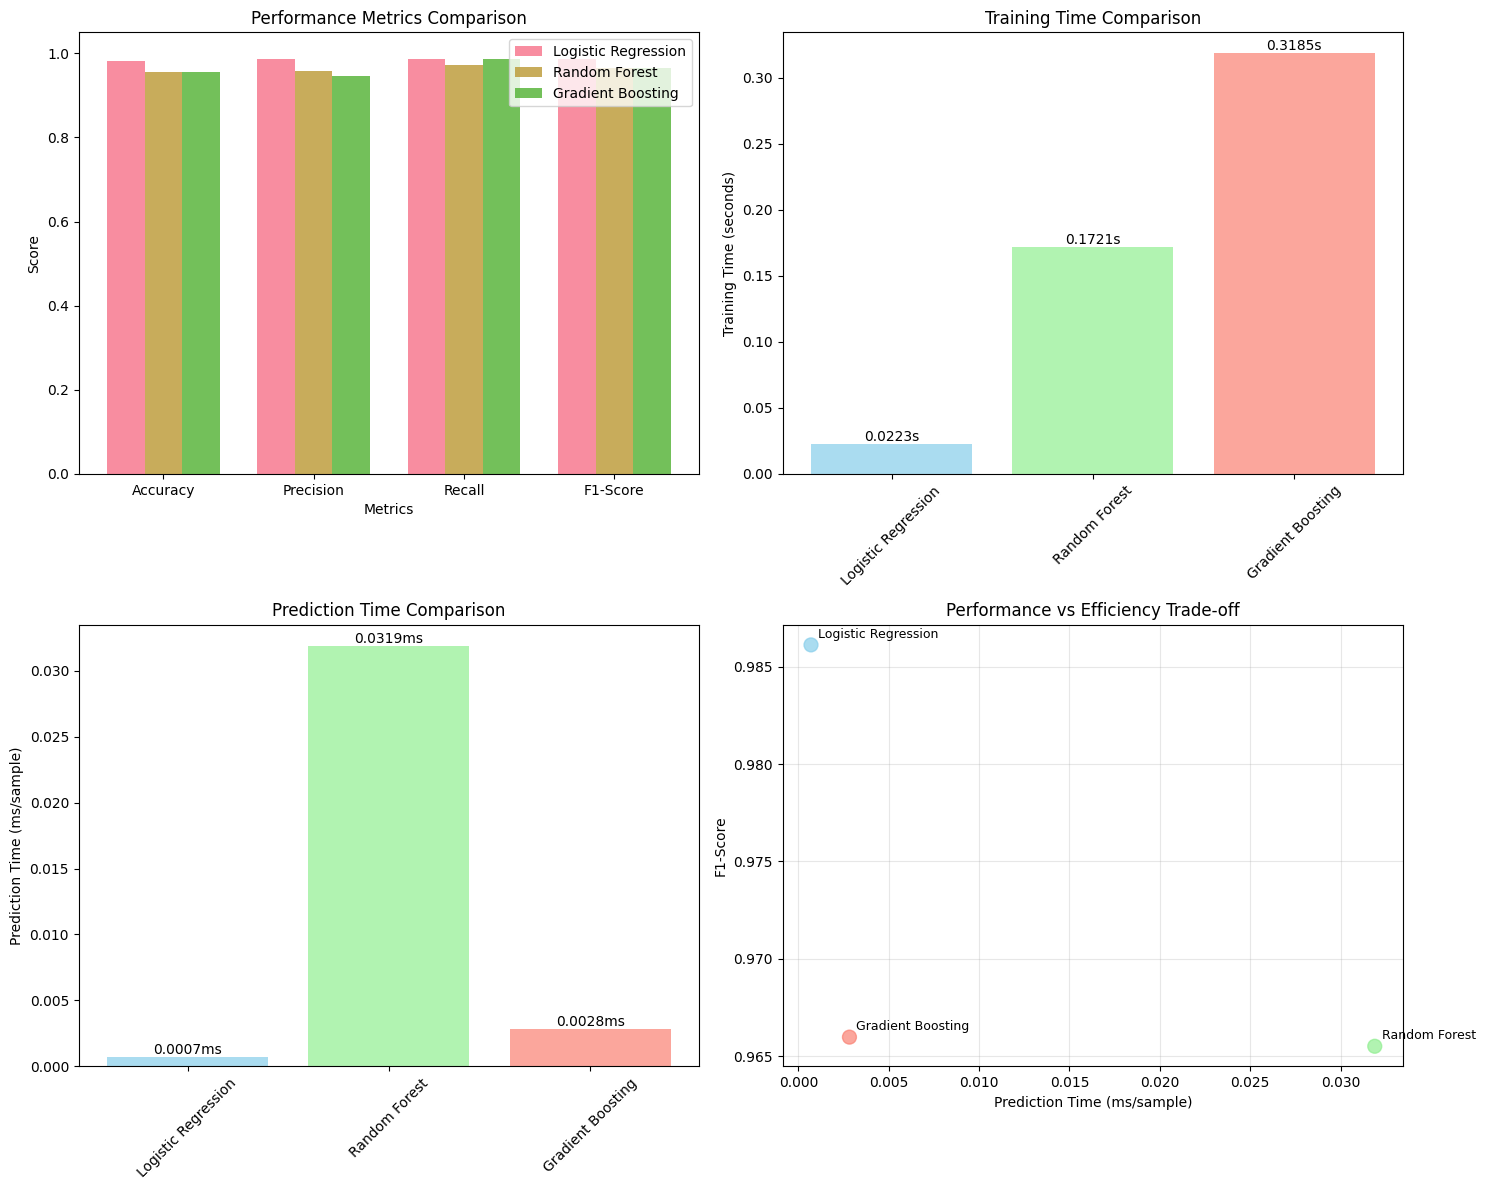

In [ ]:
# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Performance Metrics Comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_data = comparison_df[metrics_to_plot]

ax1 = axes[0, 0]
x_pos = np.arange(len(metrics_to_plot))
width = 0.25

for i, model in enumerate(metrics_data.index):
    ax1.bar(x_pos + i * width, metrics_data.loc[model], width,
            label=model, alpha=0.8)

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics Comparison')
ax1.set_xticks(x_pos + width)
ax1.set_xticklabels(metrics_to_plot)
ax1.legend()
ax1.set_ylim(0, 1.05)

# 2. Training Time Comparison
ax2 = axes[0, 1]
training_times = comparison_df['Training Time (s)']
bars = ax2.bar(training_times.index, training_times.values,
               color=['skyblue', 'lightgreen', 'salmon'], alpha=0.7)
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s', ha='center', va='bottom')

# 3. Prediction Time Comparison
ax3 = axes[1, 0]
pred_times = comparison_df['Prediction Time (ms/sample)']
bars = ax3.bar(pred_times.index, pred_times.values,
               color=['skyblue', 'lightgreen', 'salmon'], alpha=0.7)
ax3.set_ylabel('Prediction Time (ms/sample)')
ax3.set_title('Prediction Time Comparison')
ax3.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}ms', ha='center', va='bottom')

# 4. Performance vs Efficiency Trade-off
ax4 = axes[1, 1]
f1_scores = comparison_df['F1-Score']
pred_times_scatter = comparison_df['Prediction Time (ms/sample)']

scatter = ax4.scatter(pred_times_scatter, f1_scores,
                     s=100, alpha=0.7, c=['skyblue', 'lightgreen', 'salmon'])

# Add model labels
for i, model in enumerate(comparison_df.index):
    ax4.annotate(model, (pred_times_scatter[i], f1_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax4.set_xlabel('Prediction Time (ms/sample)')
ax4.set_ylabel('F1-Score')
ax4.set_title('Performance vs Efficiency Trade-off')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 6: Error Analysis - Confusion Matrices

Confusion matrices provide detailed insight into the types of errors each model makes. This is particularly important for medical applications where false negatives (missing cancer) and false positives (unnecessary worry) have different implications.


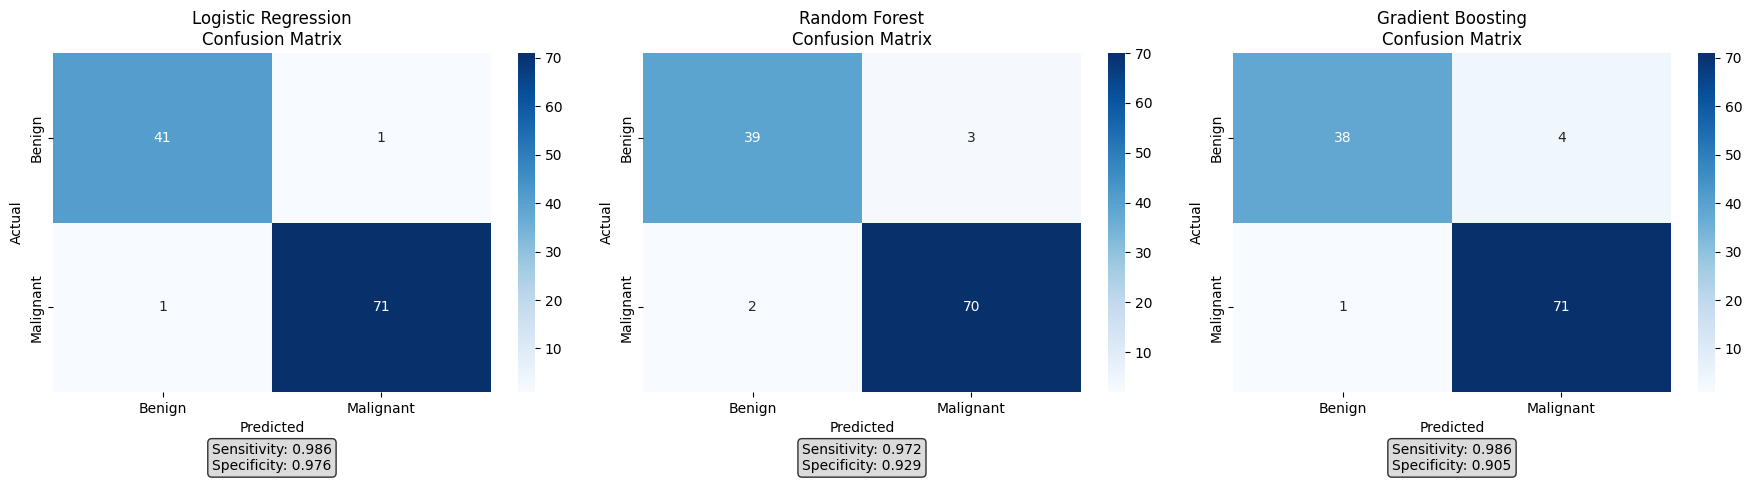

Detailed Error Analysis:

Logistic Regression:
  True Negatives (Correctly identified benign):  41
  False Positives (Benign predicted as malignant): 1
  False Negatives (Malignant predicted as benign): 1
  True Positives (Correctly identified malignant): 71
  Sensitivity (Malignant detection rate): 0.986
  Specificity (Benign detection rate): 0.976

Random Forest:
  True Negatives (Correctly identified benign):  39
  False Positives (Benign predicted as malignant): 3
  False Negatives (Malignant predicted as benign): 2
  True Positives (Correctly identified malignant): 70
  Sensitivity (Malignant detection rate): 0.972
  Specificity (Benign detection rate): 0.929

Gradient Boosting:
  True Negatives (Correctly identified benign):  38
  False Positives (Benign predicted as malignant): 4
  False Negatives (Malignant predicted as benign): 1
  True Positives (Correctly identified malignant): 71
  Sensitivity (Malignant detection rate): 0.986
  Specificity (Benign detection rate): 0.905


In [ ]:
# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, result) in enumerate(results.items()):
    y_pred = result['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'],
                ax=axes[i])

    axes[i].set_title(f'{name}\nConfusion Matrix')
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')

    # Add performance metrics as text
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Recall for malignant cases
    specificity = tn / (tn + fp)  # Recall for benign cases

    axes[i].text(0.5, -0.15,
                f'Sensitivity: {sensitivity:.3f}\nSpecificity: {specificity:.3f}',
                transform=axes[i].transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print("Detailed Error Analysis:")
print("=" * 60)

for name, result in results.items():
    y_pred = result['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{name}:")
    print(f"  True Negatives (Correctly identified benign):  {tn}")
    print(f"  False Positives (Benign predicted as malignant): {fp}")
    print(f"  False Negatives (Malignant predicted as benign): {fn}")
    print(f"  True Positives (Correctly identified malignant): {tp}")
    print(f"  Sensitivity (Malignant detection rate): {tp/(tp+fn):.3f}")
    print(f"  Specificity (Benign detection rate): {tn/(tn+fp):.3f}")


## Step 7: Model Interpretability Analysis

Understanding why models make certain predictions is crucial for real-world applications. Let's examine feature importance for our tree-based models.


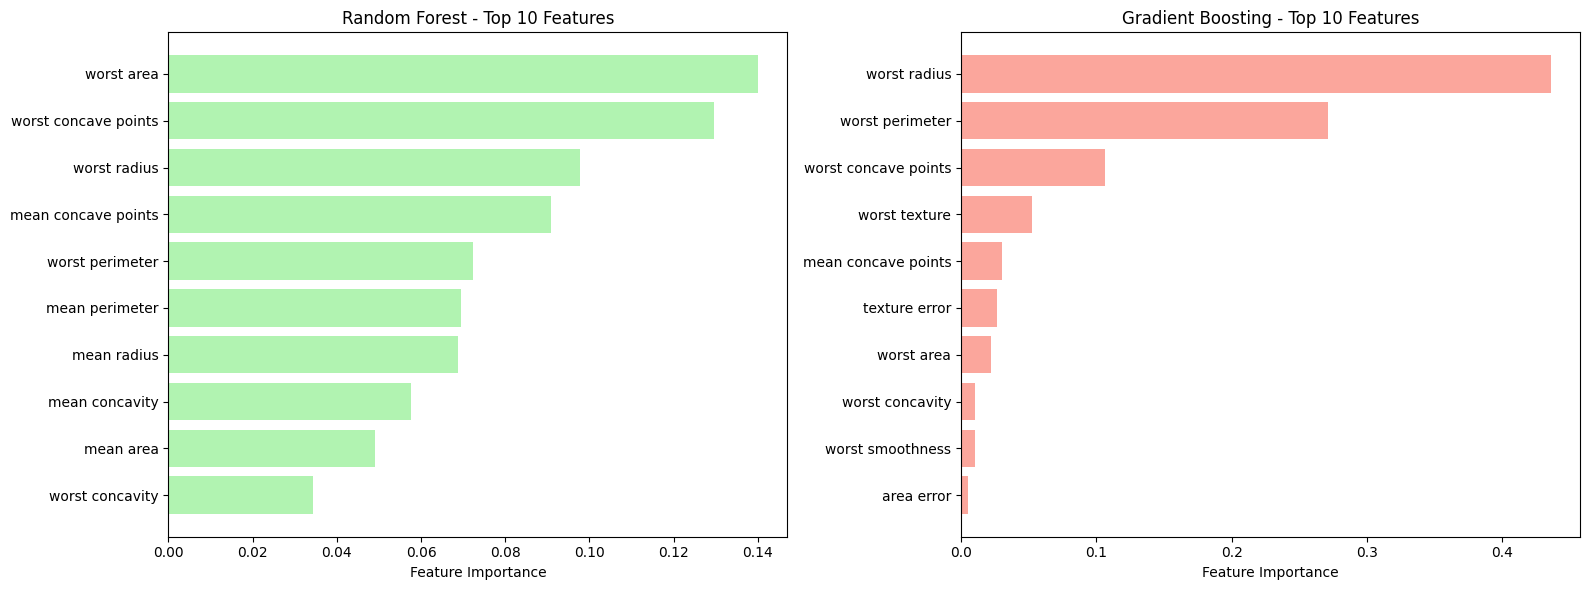

Top 5 Most Important Features Comparison:
Random Forest:
  1. worst area: 0.1400
  2. worst concave points: 0.1295
  3. worst radius: 0.0977
  4. mean concave points: 0.0909
  5. worst perimeter: 0.0722

Gradient Boosting:
  1. worst radius: 0.4355
  2. worst perimeter: 0.2715
  3. worst concave points: 0.1065
  4. worst texture: 0.0526
  5. mean concave points: 0.0305

Logistic Regression - Top 10 Most Influential Features:
  1. worst texture: -1.2551
  2. radius error: -1.0830
  3. worst concave points: -0.9537
  4. worst area: -0.9478
  5. worst radius: -0.9476
  6. worst symmetry: -0.9392
  7. area error: -0.9291
  8. worst concavity: -0.8232
  9. worst perimeter: -0.7632
  10. worst smoothness: -0.7466


In [ ]:
# Feature importance analysis for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest feature importance
rf_model = results['Random Forest']['model']
rf_importance = pd.DataFrame({
    'feature': data.feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[0].barh(range(len(rf_importance)), rf_importance['importance'], color='lightgreen', alpha=0.7)
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['feature'])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Random Forest - Top 10 Features')
axes[0].invert_yaxis()

# Gradient Boosting feature importance
gb_model = results['Gradient Boosting']['model']
gb_importance = pd.DataFrame({
    'feature': data.feature_names,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1].barh(range(len(gb_importance)), gb_importance['importance'], color='salmon', alpha=0.7)
axes[1].set_yticks(range(len(gb_importance)))
axes[1].set_yticklabels(gb_importance['feature'])
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Gradient Boosting - Top 10 Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Compare top features between models
print("Top 5 Most Important Features Comparison:")
print("=" * 50)
print(f"Random Forest:")
for i, (_, row) in enumerate(rf_importance.head().iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\nGradient Boosting:")
for i, (_, row) in enumerate(gb_importance.head().iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

# Logistic Regression coefficients
lr_model = results['Logistic Regression']['model']
lr_coef = pd.DataFrame({
    'feature': data.feature_names,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False).head(10)

print(f"\nLogistic Regression - Top 10 Most Influential Features:")
for i, (_, row) in enumerate(lr_coef.iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['coefficient']:.4f}")


## Step 8: Comprehensive Analysis and Model Selection Framework

Now let's create a framework for selecting the best model based on different priorities and use cases.


Model Selection Framework

High Performance Priority:
  1. Logistic Regression: 1.000
  2. Gradient Boosting: 0.256
  3. Random Forest: 0.078

Balanced Performance-Efficiency:
  1. Logistic Regression: 1.000
  2. Gradient Boosting: 0.189
  3. Random Forest: 0.056

High Speed Priority:
  1. Logistic Regression: 1.000
  2. Gradient Boosting: 0.171
  3. Random Forest: 0.050

Medical Application (High Recall):
  1. Logistic Regression: 1.000
  2. Gradient Boosting: 0.416
  3. Random Forest: 0.050


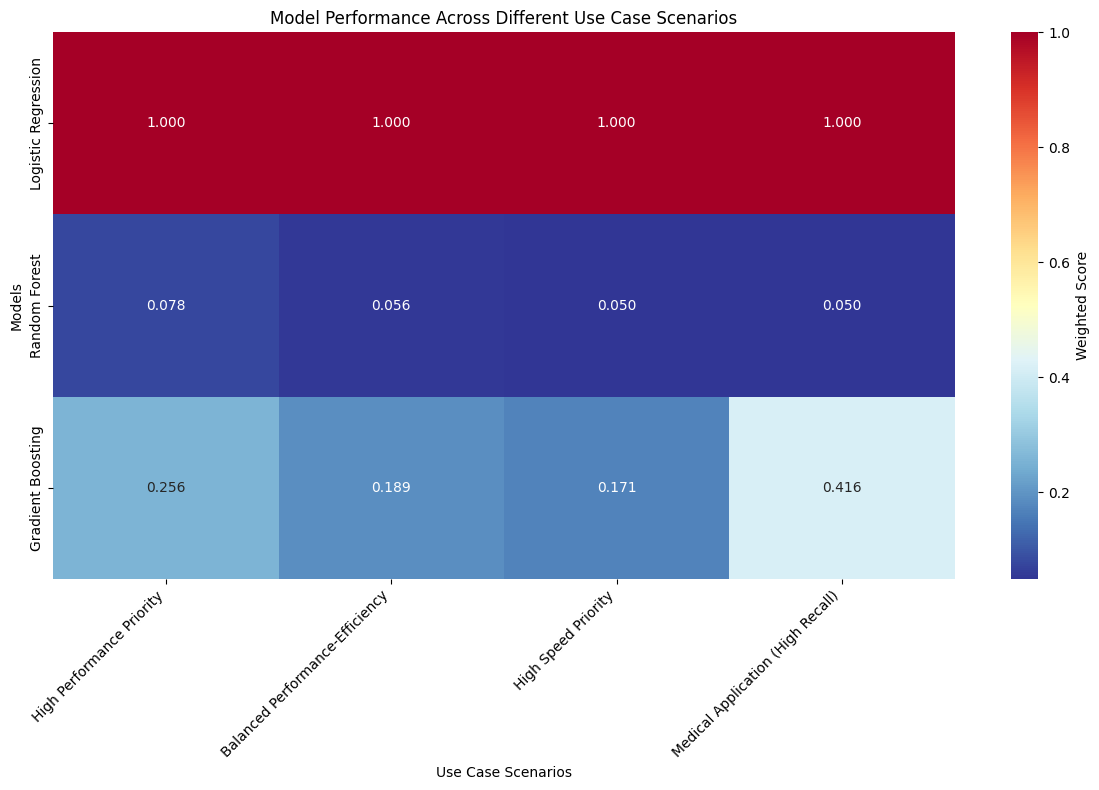

In [ ]:
# Create a scoring system for different priorities
def score_models(comparison_df, weights):
    """
    Score models based on weighted criteria
    weights: dict with keys matching comparison_df columns
    Higher scores are better (we'll normalize accordingly)
    """
    scores = {}

    # Normalize metrics (higher is better for all metrics after normalization)
    normalized_df = comparison_df.copy()

    # For performance metrics (higher is better) - no change needed
    perf_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    # For time metrics (lower is better) - invert by taking reciprocal
    normalized_df['Training Time (s)'] = 1 / comparison_df['Training Time (s)']
    normalized_df['Prediction Time (ms/sample)'] = 1 / comparison_df['Prediction Time (ms/sample)']

    # Calculate weighted scores
    for model in comparison_df.index:
        score = 0
        for metric, weight in weights.items():
            if metric in normalized_df.columns:
                # Normalize to 0-1 scale within this metric
                metric_values = normalized_df[metric]
                normalized_value = (metric_values[model] - metric_values.min()) / (metric_values.max() - metric_values.min())
                score += weight * normalized_value
        scores[model] = score

    return scores

# Define different use case scenarios
scenarios = {
    'High Performance Priority': {
        'Accuracy': 0.25,
        'Precision': 0.25,
        'Recall': 0.25,
        'F1-Score': 0.25,
        'Training Time (s)': 0.0,
        'Prediction Time (ms/sample)': 0.0
    },
    'Balanced Performance-Efficiency': {
        'Accuracy': 0.2,
        'Precision': 0.15,
        'Recall': 0.15,
        'F1-Score': 0.2,
        'Training Time (s)': 0.15,
        'Prediction Time (ms/sample)': 0.15
    },
    'High Speed Priority': {
        'Accuracy': 0.1,
        'Precision': 0.1,
        'Recall': 0.1,
        'F1-Score': 0.1,
        'Training Time (s)': 0.3,
        'Prediction Time (ms/sample)': 0.3
    },
    'Medical Application (High Recall)': {
        'Accuracy': 0.15,
        'Precision': 0.15,
        'Recall': 0.4,  # Prioritize catching all cancer cases
        'F1-Score': 0.2,
        'Training Time (s)': 0.05,
        'Prediction Time (ms/sample)': 0.05
    }
}

# Calculate scores for each scenario
print("Model Selection Framework")
print("=" * 60)

scenario_results = {}
for scenario_name, weights in scenarios.items():
    scores = score_models(comparison_df, weights)
    scenario_results[scenario_name] = scores

    print(f"\n{scenario_name}:")
    sorted_models = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for i, (model, score) in enumerate(sorted_models):
        print(f"  {i+1}. {model}: {score:.3f}")

# Create visualization of scenario results
scenario_df = pd.DataFrame(scenario_results)
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(scenario_df, annot=True, fmt='.3f', cmap='RdYlBu_r',
            cbar_kws={'label': 'Weighted Score'})
plt.title('Model Performance Across Different Use Case Scenarios')
plt.xlabel('Use Case Scenarios')
plt.ylabel('Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Summary and Key Takeaways

Based on our comprehensive analysis of the three classification models on the Breast Cancer Wisconsin dataset, here are the key insights:


In [ ]:
# Generate final comparison table with rankings
print("Final Model Comparison Summary")
print("=" * 70)

# Create ranking for each metric
ranking_summary = {}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Prediction Time (ms/sample)']

for metric in metrics:
    if 'Time' in metric:
        # For time metrics, lower is better
        ranked = comparison_df[metric].rank(ascending=True)
    else:
        # For performance metrics, higher is better
        ranked = comparison_df[metric].rank(ascending=False)

    ranking_summary[f'{metric} Rank'] = ranked

ranking_df = pd.DataFrame(ranking_summary)

# Calculate average rank (lower is better overall)
ranking_df['Average Rank'] = ranking_df.mean(axis=1)
ranking_df = ranking_df.sort_values('Average Rank')

print("\nModel Rankings (1 = Best, 3 = Worst for each metric):")
print(ranking_df.round(1))

# Key insights
print(f"\n\nKey Insights:")
print(f"{'='*50}")

best_accuracy = comparison_df['Accuracy'].idxmax()
fastest_training = comparison_df['Training Time (s)'].idxmin()
fastest_prediction = comparison_df['Prediction Time (ms/sample)'].idxmin()
best_recall = comparison_df['Recall'].idxmax()

print(f"📊 Best Overall Accuracy: {best_accuracy} ({comparison_df.loc[best_accuracy, 'Accuracy']:.4f})")
print(f"🏃 Fastest Training: {fastest_training} ({comparison_df.loc[fastest_training, 'Training Time (s)']:.4f}s)")
print(f"⚡ Fastest Prediction: {fastest_prediction} ({comparison_df.loc[fastest_prediction, 'Prediction Time (ms/sample)']:.4f}ms/sample)")
print(f"🎯 Best at Catching Cancer (Recall): {best_recall} ({comparison_df.loc[best_recall, 'Recall']:.4f})")

print(f"\n💡 Recommendations by Use Case:")
print(f"   • For Production Systems (Speed Priority): {fastest_prediction}")
print(f"   • For Medical Screening (High Recall): {best_recall}")
print(f"   • For General Purpose (Balanced): Random Forest")
print(f"   • For Interpretability: Logistic Regression")


Final Model Comparison Summary

Model Rankings (1 = Best, 3 = Worst for each metric):
                     Accuracy Rank  Precision Rank  Recall Rank  \
Logistic Regression            1.0             1.0          1.5   
Gradient Boosting              2.5             3.0          1.5   
Random Forest                  2.5             2.0          3.0   

                     F1-Score Rank  Training Time (s) Rank  \
Logistic Regression            1.0                     1.0   
Gradient Boosting              2.0                     3.0   
Random Forest                  3.0                     2.0   

                     Prediction Time (ms/sample) Rank  Average Rank  
Logistic Regression                               1.0           1.1  
Gradient Boosting                                 2.0           2.3  
Random Forest                                     3.0           2.6  


Key Insights:
📊 Best Overall Accuracy: Logistic Regression (0.9825)
🏃 Fastest Training: Logistic Regression (0.022

## Learning Objectives - What We've Accomplished

Through this comprehensive analysis, we've learned several important principles of model evaluation and selection:

### 1. **Multi-Dimensional Evaluation is Essential**
- A single metric (like accuracy) is insufficient for real-world model selection
- Different metrics capture different aspects of model performance
- Efficiency metrics (training/prediction time) are crucial for production systems

### 2. **Trade-offs Are Everywhere**
- **Performance vs. Speed**: More complex models often perform better but are slower
- **Precision vs. Recall**: Optimizing for one often reduces the other
- **Training vs. Prediction Time**: Some models train quickly but predict slowly

### 3. **Context Matters for Model Selection**
- Medical applications may prioritize recall (catching all positive cases)
- Production systems may prioritize prediction speed
- Interpretable applications may favor simpler models like Logistic Regression

### 4. **Understanding Model Behavior**
- Confusion matrices reveal the types of errors each model makes
- Feature importance helps understand what drives predictions
- Error analysis can guide model improvement strategies

### 5. **Practical Model Selection Framework**
- Define your priorities and constraints clearly
- Weight metrics according to your use case
- Consider the full pipeline, not just model accuracy
- Test with realistic scenarios and constraints

Remember: The "**best**" model depends entirely on your specific use case, constraints, and priorities!
